## Orbit Fitting:

##### AM205 Final Project

Orbit fitting for unmatched asteroid tracklet clustering.

* Paul Blankley
* Vincent Casser
* Ryan Janssen


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import clustering as cl
import util
import healpy as hp
import importlib as imp
from collections import defaultdict
import seaborn as sns 
from time import time
import visual
import pickle
import os
import pandas as pd

%matplotlib inline 

In [2]:
# Global parameters
gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

nside=8
n = -14
dt=15.0
cr=0.00124
pixels=range(hp.nside2npix(nside))

train_path = 'demo_train/UnnObs_Training_1_line_A_ec_labelled_2457308.5_pm15.0_r2.5.trans'


#### Walkthrough:

In this walkthrough, we will just focus on one (dense) pixel in the healpix sky division pattern.  This will allow us more computational speed, and a more straightforward way to show how our code works.

In [3]:
tr_results, tr_clust_ids = cl.find_clusters([281], train_path, util.lunation_center(n), g_gdots=g_gdots,dt=dt,rad=cr)

In [4]:
agg_dict, par_results, chi_res = cl.get_cluster_level_dicts(tr_clust_ids,train_path,nside,n,281,g=0.4,gdot=0.0)

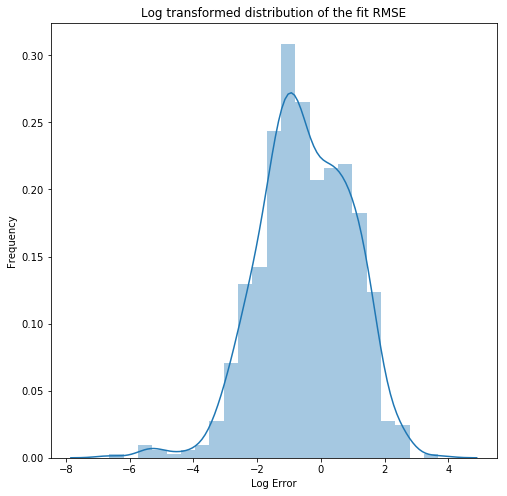

In [5]:
fig,ax = plt.subplots(figsize=(8,8))
sns.distplot([np.log(v) for v in chi_res.values()],ax=ax)
plt.title('Log transformed distribution of the fit RMSE')
plt.xlabel('Log Error')
plt.ylabel('Frequency')

In [6]:
xx=4.5
print('Mean orbit fit RMSE: {:.5}'.format(np.mean(list(chi_res.values()))))
print('Median orbit fit RMSE: {:.5}'.format(np.median(list(chi_res.values()))))
print('Number of fits below {} RMSE: {}'.format(xx,len([i for i in chi_res.values() if i<xx])))
print('Percent of fits below {} RMSE: {:.5}'.format(xx,len([i for i in chi_res.values() if i<xx])/len(chi_res)))

Mean orbit fit RMSE: 1.4586
Median orbit fit RMSE: 0.58418
Number of fits below 4.5 RMSE: 672
Percent of fits below 4.5 RMSE: 0.93075


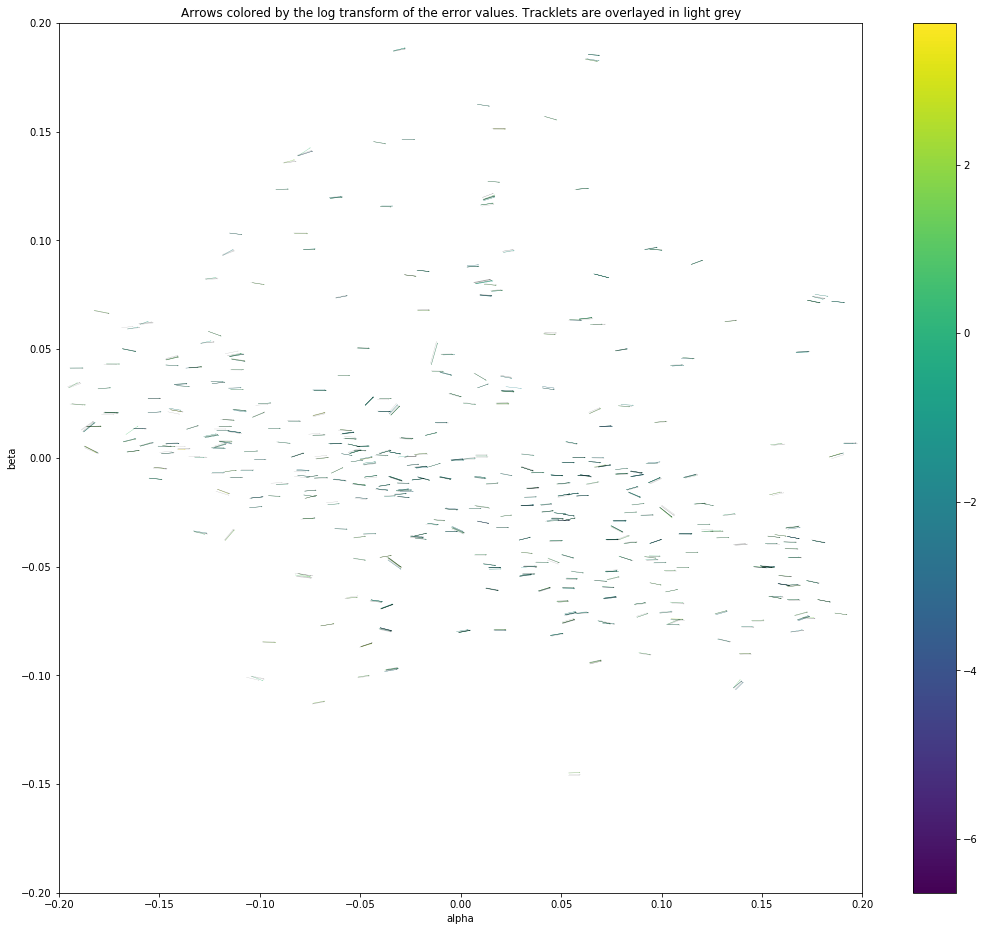

In [7]:
visual.vis_cluster_tracklet_arrows(par_results,agg_dict,util.lunation_center(n),chi_res,log=True,save=False)

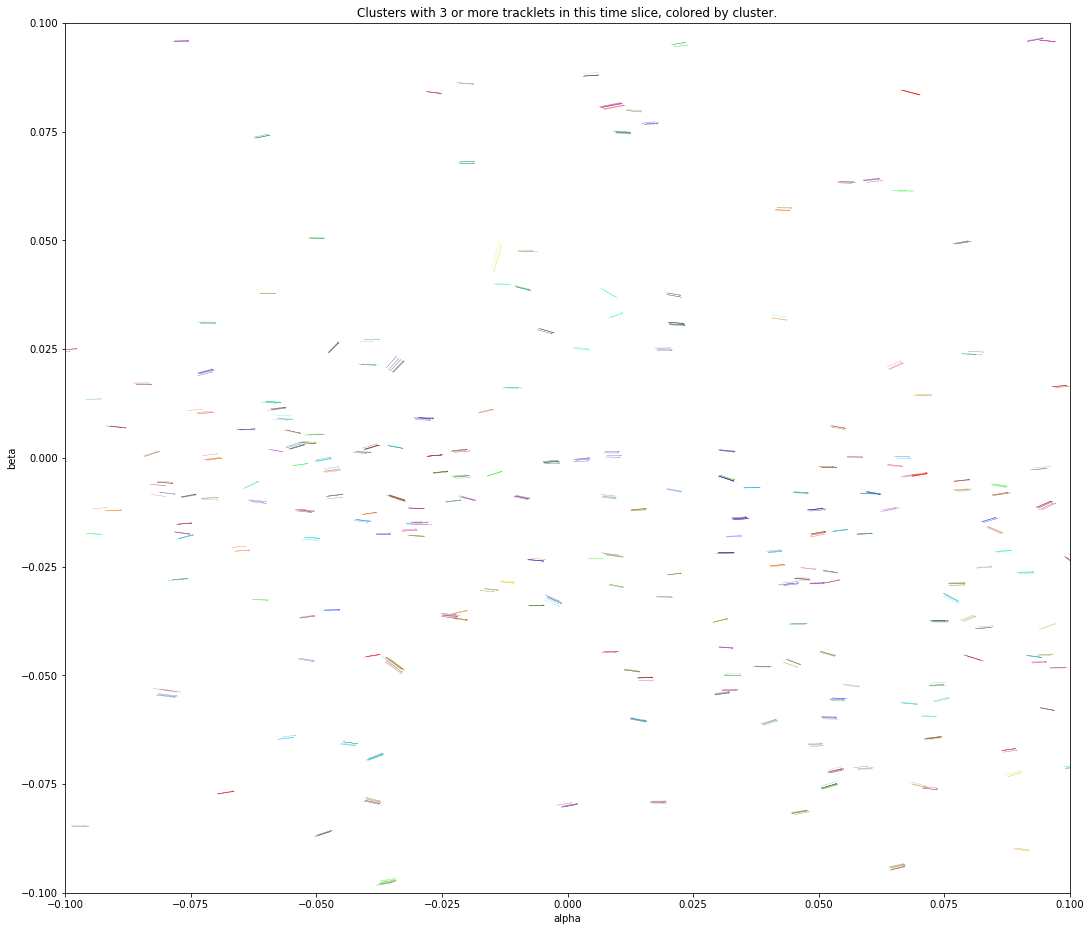

In [8]:
visual.cluster_by_color(train_path,281,nside,n,cluster_id_dict=tr_clust_ids,outpath='clust_by_color',save=False)

### Two neighboring clusters before cluster extension:

As you can see these two clusters (minus one tracklet) make up the larger post-extension cluster.

In [9]:
params, fv, chisq, chisq_arr_2558 = cl.full_fit_t_loss(util.lunation_center(n),0.4,0.0, agg_dict[815])
a_obs_2558 = [ob for trkl in agg_dict[815] for ob in trkl]
[(ob[0],float(round(ob[3],5)),float(round(ob[4],5)),ch) for ob,ch in zip(a_obs_2558,chisq_arr_2558)]

[('K05T82G_013', 0.03805, 0.07143, 0.37692756566700281),
 ('K05T82G_013', 0.03801, 0.07142, 0.41197643945185264),
 ('K05T82G_013', 0.03797, 0.07141, 0.25497322867227717),
 ('K05T82G_013', 0.03793, 0.0714, 0.24803735806606653)]

In [10]:
params, fv, chisq, chisq_arr_2532 = cl.full_fit_t_loss(util.lunation_center(n),0.4, 0.0, agg_dict[880],use_jacobian=False)
a_obs_2532 = [ob for trkl in agg_dict[880] for ob in trkl]
[(ob[0],float(round(ob[3],5)),float(round(ob[4],5)),ch) for ob,ch in zip(a_obs_2532,chisq_arr_2532)]

[('K05T82G_012', 0.0533, 0.07525, 3.3980799798976471),
 ('K05T82G_012', 0.05328, 0.07524, 3.1918260732342447),
 ('K05T82G_012', 0.05326, 0.07523, 3.4302538939677478),
 ('K05T82G_012', 0.05324, 0.07523, 3.4913219229724644),
 ('K05T82G_015', 0.00992, 0.06401, 5.8808984036611003),
 ('K05T82G_015', 0.00987, 0.064, 5.8842695046804181),
 ('K05T82G_015', 0.00982, 0.06399, 5.8560603717873656),
 ('K05T82G_015', 0.00977, 0.06397, 5.8930999723745918),
 ('K05T82G_017', -0.03761, 0.04953, 2.7077010632755796),
 ('K05T82G_017', -0.03767, 0.04951, 2.5884835907430661),
 ('K05T82G_017', -0.03773, 0.04949, 2.6674565615016705),
 ('K05T82G_017', -0.0378, 0.04948, 2.5505466410752105)]

### Visually

We can see the two distinct clusters here before we extend.

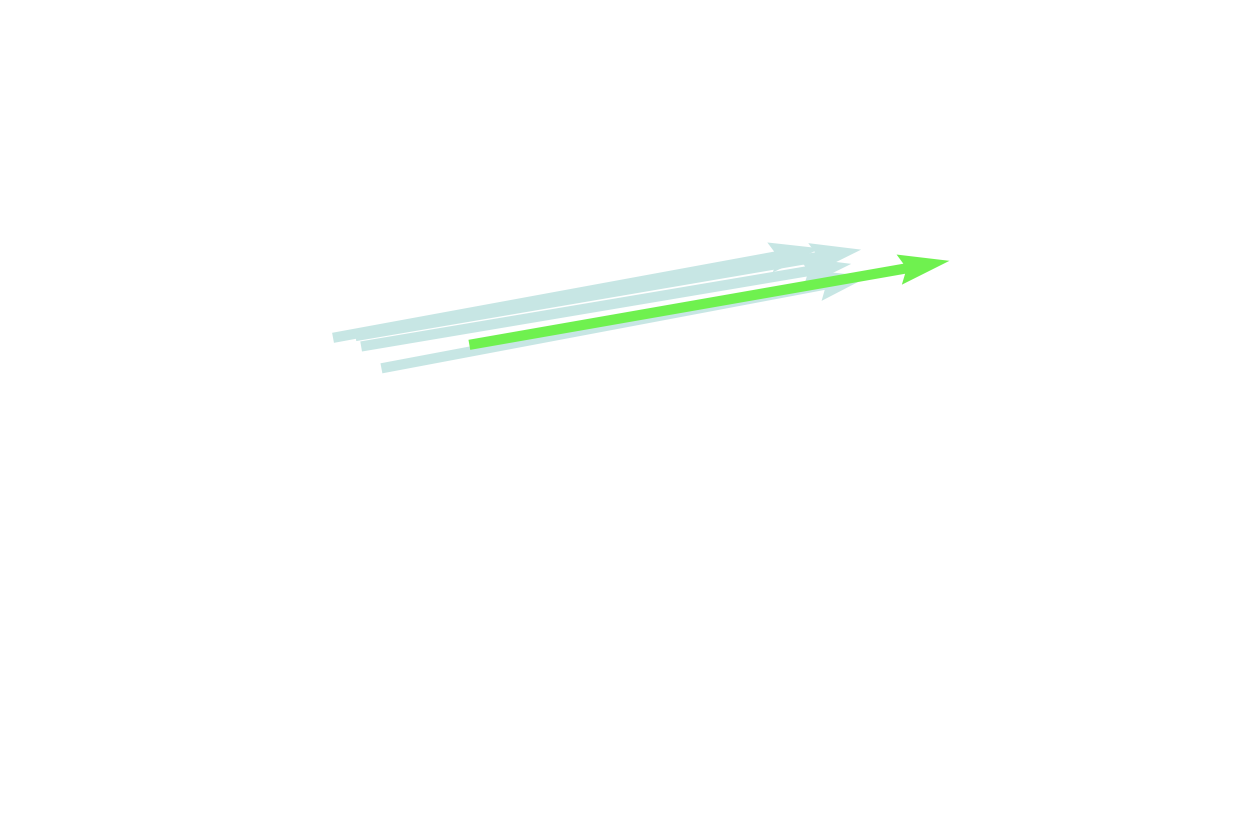

### This is a new cluster after we extend:

Here we extended the cluster by re-transforming with the new g/gdot and clustering again.  As you may notice, the elements with 013 and 016 tails were correctly added to the cluster.

In [11]:
cc_extend, ccid_extend = cl.fit_extend(train_path, tr_results, [281], nside, n,new_rad=0.0045)

In [12]:
ad_extend, pr_extend, cres_extend = cl.get_cluster_level_dicts(ccid_extend,train_path,nside,n,281,g=0.4,gdot=0.0)

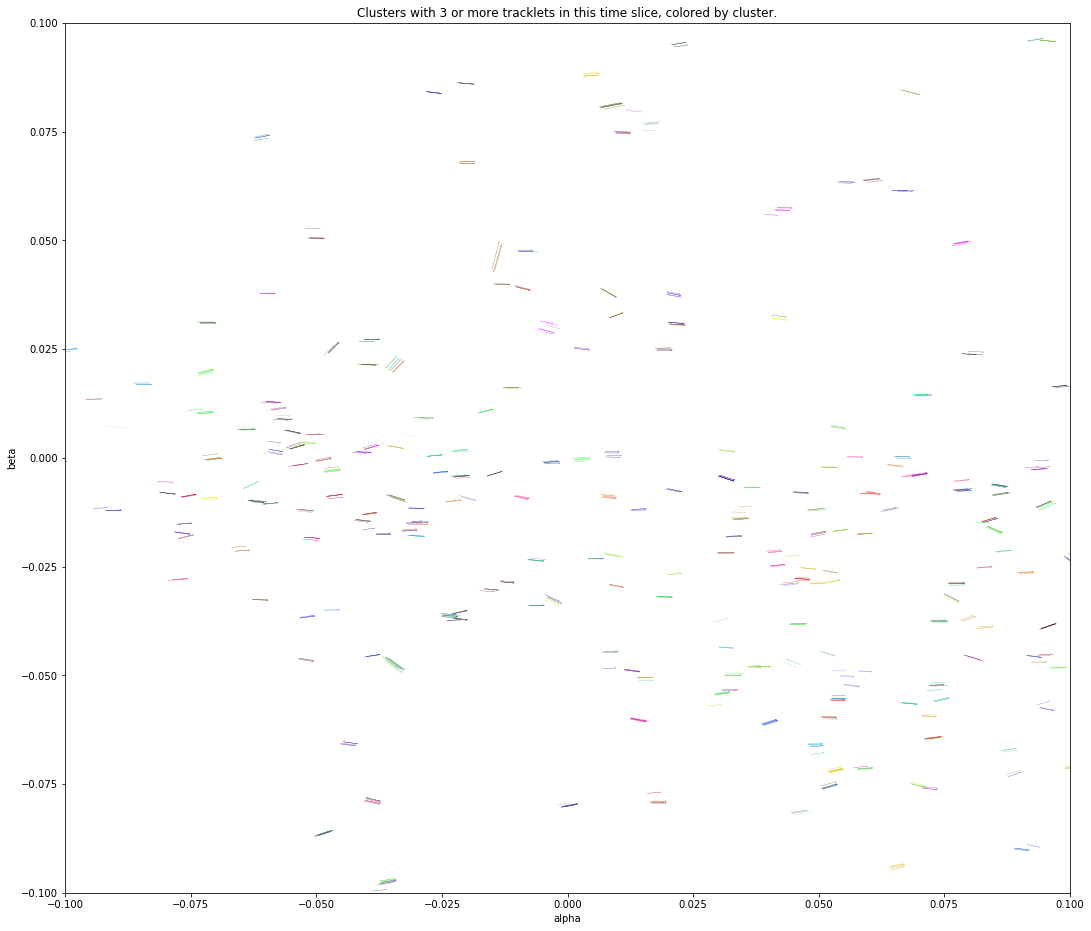

In [13]:
visual.cluster_by_color(train_path,281,nside,n,cluster_id_dict=ccid_extend,outpath='clust_by_color_extend',save=False)

In [14]:
a2_obs = [ob for trkl in ad_extend[643] for ob in trkl]
[(ob[0],float(round(ob[3],5)),float(round(ob[4],5))) for ob in a2_obs]  

[('K05T82G_012', 0.0533, 0.07525),
 ('K05T82G_012', 0.05328, 0.07524),
 ('K05T82G_012', 0.05326, 0.07523),
 ('K05T82G_012', 0.05324, 0.07523),
 ('K05T82G_013', 0.03805, 0.07143),
 ('K05T82G_013', 0.03801, 0.07142),
 ('K05T82G_013', 0.03797, 0.07141),
 ('K05T82G_013', 0.03793, 0.0714),
 ('K05T82G_014', 0.01921, 0.06653),
 ('K05T82G_014', 0.01919, 0.06652),
 ('K05T82G_014', 0.01916, 0.06651),
 ('K05T82G_014', 0.01914, 0.06651),
 ('K05T82G_014', 0.01912, 0.0665),
 ('K05T82G_014', 0.01911, 0.0665),
 ('K05T82G_014', 0.01906, 0.06649),
 ('K05T82G_015', 0.00992, 0.06401),
 ('K05T82G_015', 0.00987, 0.064),
 ('K05T82G_015', 0.00982, 0.06399),
 ('K05T82G_015', 0.00977, 0.06397),
 ('K05T82G_016', 0.00557, 0.06282),
 ('K05T82G_016', 0.00552, 0.0628),
 ('K05T82G_016', 0.0055, 0.0628),
 ('K05T82G_017', -0.03761, 0.04953),
 ('K05T82G_017', -0.03767, 0.04951),
 ('K05T82G_017', -0.03773, 0.04949),
 ('K05T82G_017', -0.0378, 0.04948)]

#### Visually 

Here we see the two previously distinct clusters come together and another (previously) singleton was added to the cluster.
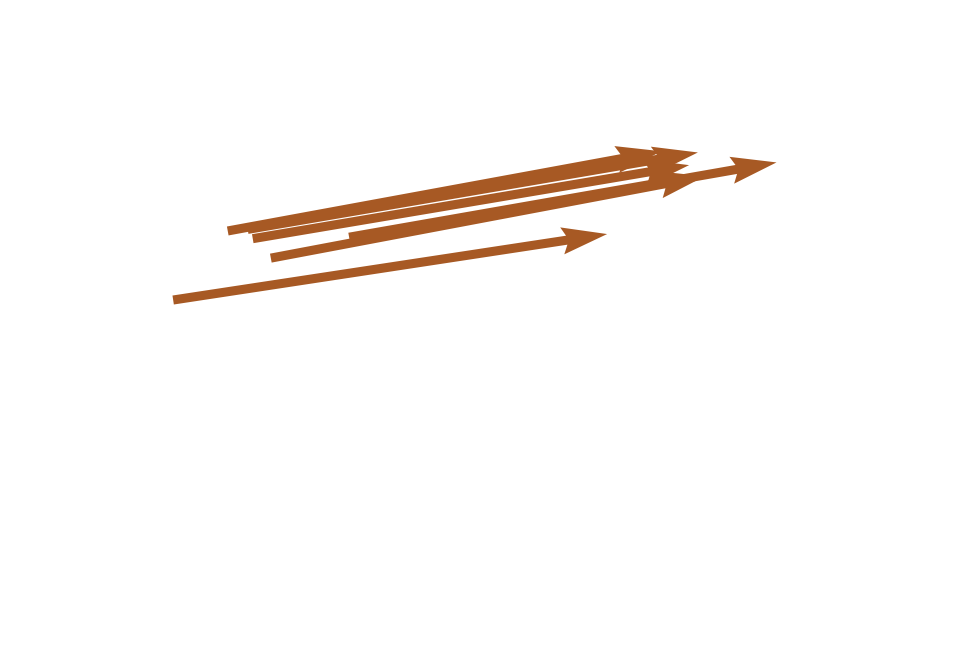

##### Fit and Extend:

Although this Fit and Extend method works in some cases like the above, it does not add a lot to our model, and it takes quite a chunk of computational time to run for the whole dataset.  Because it does not add a lot, we exclude this step from our method.

##### Clustering the clusters:

One step we found did add value to the model, was clustering the clusters within each healpix space (or pixel).  This allowed us to aggregate up some clusters so we did not have so many small 3 element clusters right on top of each other.

In [15]:
cc_cc, ccid_cc = cl.cluster_clusters(train_path, tr_results, [281], nside, n)

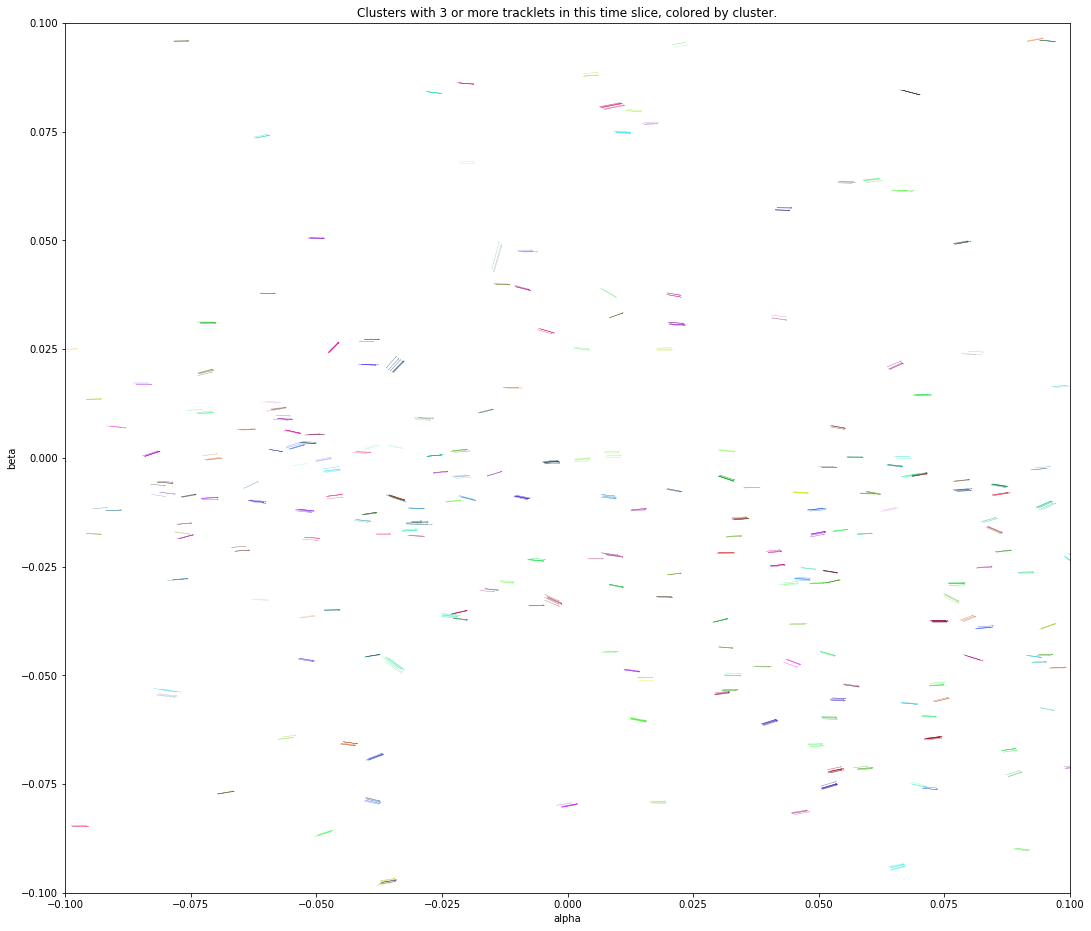

In [16]:
visual.cluster_by_color(train_path,281,nside,n,cluster_id_dict=ccid_cc,outpath='clust_by_color_coc',save=False)

In [17]:
print('We now have',len(set(ccid_cc.values())),'clusters where we previously had',len(set(tr_clust_ids.values())))

We now have 426 clusters where we previously had 722


##### Postprocessing Step:

Now that we have clustered the clusters in each spatial window we have a more robust estimate for our fitted orbit parameters.  Since we are relatively confident in our orbital parameters, we can transform the orbital parameters we have been using: $\alpha$, $\dot\alpha$, $\beta$, $\dot\beta$, $\gamma$, and $\dot\gamma$ into the commonly used "orbital elements" which are given by the six parameters: $a$, $E$, $i$, $\Omega$, $\omega$, and $m$. In the orbital elements paradigm, $a$ is the semi-major axis of the ellipse, $E$ is the eccentricity, $i$ is the inclination, $\Omega$ is the longitude of the ascending node, $\omega$ is the angle to the periapsis (point the asteroid is closest to the sun) from the line of nodes, and $m$ is the mean anomaly, where the asteroid is located on its orbit.  The line of nodes is the line created from the intersection of the orbital plane of the asteroid and the reference plane, in our case the equatorial plane of the earth. This transform takes us back into the realm of well-established astronomy orbit parameters.  Although the orbital elements are a well established convention in astronomy, we have a much better reason than convention for choosing this transform.  

The beauty of this transform is that we go from several parameters dependent on time, to only one parameter dependent on time.  The rest of the orbital elements are not strictly independent of time, but they are approximately independent, which is close enough for our purposes. This means once we do this transform, we can compare the first five orbital element parameters across *ALL* our time frames.  We can even compare clusters we have made in different years and check if they are related! 


In [18]:
# Postprocessing step
coc_fd = cl.postprocessing(train_path, cc_cc, [281], nside, n)

# Note: we only take the first 5 below because plotting the orbit enumerates the 6th 
coc_orbfits = np.array([v[0][:5] for v in coc_fd.values()])

### Let's check out some orbits! 

Now that the postprocessing step is done, we have orbits in terms of their orbital elements, which we can make a nice 3D plot of below.

If you look closely below you will see one orbit that looks like a straight line to the sun.  Since our plotting technique does not have the capability to plot hyperbolic orbits (orbits with eccentricity > 1), they appear as straight lines to the sun.

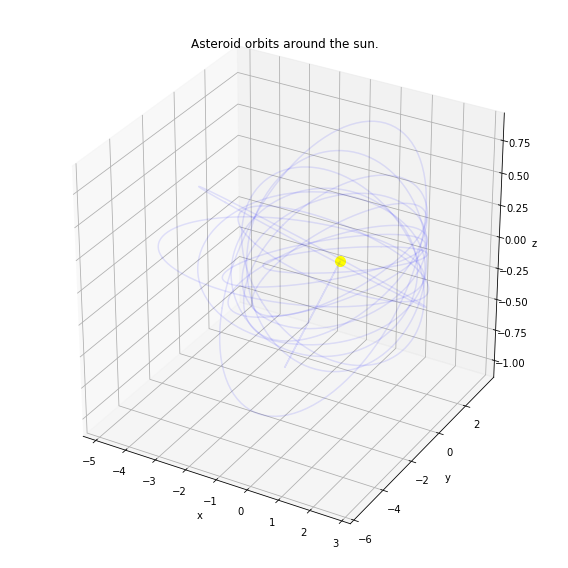

In [19]:
rc = np.array([v[1] for v in coc_fd.values()]).argsort()[:15]
orb_elements = np.array([c for c in coc_orbfits[rc,:]])

visual.vis_orbits(orb_elements,limits=False,figsize=(8,8),save=False)

#### We have just walked you thought all the steps we do to cluster within a lunar center

The next step is to cluster across lunar centers.  For this we will have to run the entire training data to get the orbital elemnents for each cluster we end up with after the initial cluster and the cluster of cluster's steps. Since all that data takes around 2-3 hours to run, we pre-ran the data and saved it to pickle files in a seperate folder.  

NOTE: If you want access to the data folder you can email me (Paul Blankley) at my .edu address, or you can take the 2-3 hours with the driver file, by uncommenting the training section, provided you have the initial training .mpc file.

In [20]:
# NOTE: THIS WILL NOT WORK IF YOU DO NOT HAVE THE REALTED DATA FOLDER 
home_dir = os.path.dirname(os.path.abspath('data/train/UnnObs_Training_1_line_A_ec.mpc'))
fit_dicts = []
print('Starting month over month cluster run...')
for prog, n in enumerate(range(-825,14)):

    train_file = os.path.join(home_dir, 'UnnObs_Training_1_line_A_ec_{}_pm15.0_r2.5.trans'.format(str(util.lunation_center(n))))

    if os.path.isfile(train_file):
        # Get the previously calculated result
        with open(os.path.join(home_dir,'train_result_{}_orbelem.pickle'.format(str(util.lunation_center(n)))),'rb') as handle:
            fit_dict = pickle.load(handle)
        fit_dicts.append(fit_dict)

print('Data loaded...')

Starting month over month cluster run...
Data loaded...


#### Tuning the hyperparameter:

In the cluster between months (and years!) we have a hyperparameter to tune.  We need to fine the cluster radius for our KD Tree that will allow the cluster radius to be as big as possible while keeping error low.  To come up with a good estimate for this radius, we perform a little analysis below and look at the elbow plot.

In [21]:
# rrr = np.arange(.01,.26,.025)
# ss,pp,ff = [],[],[]

# for r in rrr:
#     fi, fi_cid = cl.cluster_months(fit_dicts,rad=r)
#     su,pt,fa = util.evalu(util.allocate(fi))
#     ss.append(su)
#     pp.append(pt)
#     ff.append(fa)

In [22]:
# alp = 0.6
# fig,ax=plt.subplots(figsize=(10,10))
# ax.plot(rrr,ss,label='Successes',alpha=alp)
# ax.plot(rrr,pp,label='Potentials',alpha=alp)
# ax.plot(rrr,ff,label='Failures',alpha=alp)
# ax.set_xlabel('Cluster Radius')
# ax.set_ylabel('Count')
# ax.set_title('Meta-clusters radius tuning.')
# sns.despine()
# plt.legend()


### What is a good choice for our new radius?

Since 0.05 is right around where the elbow starts decreasing quickly, we chose to go with a cluster over months radius of 0.05.

In [23]:
# Cluster over months with our new cluster radius
final_dict, final_dict_cid = cl.cluster_months(fit_dicts,rad=0.05)
print('Cluster over months finished!')

Cluster over months finished!


### How to allocate tracklets to clusters:

Since we are again using a KD Tree to cluster, there is the possibility that multiple clusters "claim" the same tracklet, meaning that tracklet is within the acceptable radius in our KD Tree for all the clusters that claim the tracklet. This means we must come up with a heuristic for allocating tracklets to clusters in a manner that will give us the best shot at getting high quality clusters.  If cluster A and cluster B claim the same tracklet, which cluster should "get" the tracklet? We present four different heuristics for allocating tracklets to clusters.


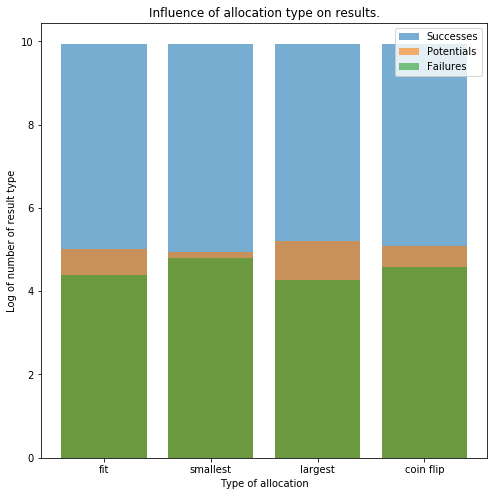

In [24]:
# Get the data 
valls = []
for me in ['fit','smallest','largest','coin']:
    vall = np.array(util.evalu(util.allocate(final_dict,method=me)))
    valls.append(vall)
valls = np.array(valls)

# Plot the data
fig,ax = plt.subplots(figsize=(8,8))
for lab,v in zip(['Successes','Potentials','Failures'],valls.T):
    ax.bar([1,2,3,4],np.log(v),label=lab,alpha=0.6)

plt.xticks([1,2,3,4],['fit','smallest','largest','coin flip'])    
plt.legend()
plt.xlabel('Type of allocation')
plt.ylabel('Log of number of result type')
plt.title('Influence of allocation type on results.')

###### Choosing a heuristic:

The first method is the "fit" method.  In this method we prioritize clusters that have low orbital fit error.  For each cluster we have a related orbital fit error measure, and we will simply assign the tracklets to the cluster with the lowest orbital fit error first, and then the next lowest and so on.  The idea here is that the better clusters will have lower fit errors because they really form an orbit, and the clusters that do not really form an orbit will have higher fit errors. The next two heuristics are based on the size of the cluster. The "smaller" heuristic prioritizes smaller clusters and then moves to larger clusters, and the "larger" heuristic does the opposite. Finally, the most straightforward heuristic we present is to randomly select a cluster from the set of clusters that claim a tracklet when assigning the tracklet to a cluster.  We call this method the "coin" method. 

From the above plot it looks like the best options will be either the fit option or the largest option. We decided to go with the fit option because it seems to perform well and it is the most defensible from a mathematical standpoint.  (e.g. the good fits are more likely to be real orbits than the bad fits) 

#### How to measure success?

We need to define what success and failure look like before we can give meaningful results.  First, in our final analysis of clusters, they cannot share tracklets. Each tracklet must be in only one cluster if it is in any cluster.  Also, to be a cluster, we must have $n\ge3$ when n is the number of tracklets. We choose to define a success as any cluster where each tracklet in the cluster actually belong together in reality.  We define a "potential" as a cluster that contains 3 or more tracklets that belong together but also contains any number of other unrealted tracklets.  The motivation for this, is that with a full scale orbit fitting process, we still could have the ability to fit a valid orbit to those 3 or more truly related tracklets. We define a failure as a cluster that does not contain 3 or more truly realted tracklets.

On the last line, we see that of the total, real population of asteroids we correctly identify and fit orbits to 70% of them.

In [31]:
# Lets check our training file to get the true number of clusters.
with open('data/train/UnnObs_Training_1_line_A_ec.mpc','r') as f:
    ids = [line[:7] for line in f]

# Let's calcualte the number of succeses, potentials, and failures we have
falloc = util.allocate(final_dict,method='fit')
s,p,f = util.evalu(falloc)
set_pred = set(v[:7] for v in falloc.values() if v!='abstain')
print('There are a total of {} distinct tracklets in the training data.'.format(len(set(final_dict_cid.keys()))))
print('There are a total of {} valid clusters in the training data.\n'.format(len(set(ids))))
print('We came up with a total of {}  clusters.'.format(s+p+f))
print('Of our clusters, we had {0} valid, {1} potential, and {2} failures.'.format(s,p,f))
print('That is {:.3}% valid, {:.3}% potential, and {:.3}% failures.\n'.format(100.*s/(s+p+f),100.*p/(s+p+f),100.*f/(s+p+f)))
print('Of our {0} valid clusters, {1} refer to unique asteroids.'.format(s,len(set_pred)))
print('Thus, we correctly cluster {:.4}% of the total asteroids.'.format(100.*len(set_pred.intersection(set(ids)))/len(set(ids))))

There are a total of 81982 distinct tracklets in the training data.
There are a total of 21359 valid clusters in the training data.

We came up with a total of 20964  clusters.
Of our clusters, we had 20732 valid, 152 potential, and 80 failures.
That is 98.9% valid, 0.725% potential, and 0.382% failures.

Of our 20732 valid clusters, 14929 refer to unique asteroids.
Thus, we correctly cluster 69.9% of the total asteroids.


### Analysis of error:

Let's take a look at how our fit error changed with the classification for each fit.

In [ ]:
fcld, fdets = util.allocate(final_dict,details=True)
ts,tp,tf,sk,pk,fk = util.evalu(fcld,details=True)

status,fit_err = [],[]
# success = 1, potential = 0, failure = -1
for k,v in fcld.items(): 
    if v in sk:
        status.append(1)
        fit_err.append(fdets[k][1])
    if v in pk:
        status.append(0)
        fit_err.append(fdets[k][1])
    if v in fk:
        status.append(-1)
        fit_err.append(fdets[k][1])

err_plot = pd.DataFrame({'status': status, 'fit_err': fit_err})

# Lets see what our average fit errors are for our three groups (successes, potentials, and failures)
display(err_plot.groupby('status',as_index=False).mean())

#### Error Analysis:

As we would expect to see the potentials and failures have much higher average RMSE than the successes.

Below, we see the distributions for these three categories.  We see a little multimodal distribution from the potentials and the failures.  One mode is well within the distribution of the successes, so we can only say that those are our likely false positives.  The other mode, however, is well enough outside of the distribution of the successes, it can inform us on how to put an upper bound on the fit error we allow for clusters that we denote as "valid" clusters.  We can say every cluster with a fit error above some value (around 4) is an invalid cluster, and (in our model) every cluster with a fit error less than 4 is a valid cluster.

In [ ]:
# Dropping 691 null values
err_plot = err_plot.dropna()

fig,ax = plt.subplots(figsize=(8,8))
sns.distplot(np.log(err_plot[err_plot['status']==1]['fit_err']),kde=False,label='Success',ax=ax)
sns.distplot(np.log(err_plot[err_plot['status']==0]['fit_err']),kde=False,label='Potential',ax=ax)
sns.distplot(np.log(err_plot[err_plot['status']==-1]['fit_err']),kde=False,label='Failure',ax=ax)
plt.ylabel('Frequency')
plt.xlabel('Orbit Fit Error')
plt.title('Distributions of log transformed orbit fit error')
plt.legend()